# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

I tried to apply the following principle learned from the Computer Vision Basics. I will start with the basic version of the pipeline principles 

Version 0:

* Crop out the Region of Interest
* Apply Canny Edge Detection (With Gaussian Blur and GrayScale)
* Compute the Hough Lines 
* Filter out and differentiate lines (This is going to be Challenge with Video Stream , where we need to take into account of slight curve)
* Overlay Lines and Lane over original input


<img src="test_images/nanodegree_pipeline.png">



## Import Packages

In [21]:
import sys

!{sys.executable} -m pip install moviepy

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

     |████████████████████████████████| 378kB 2.5MB/s eta 0:00:01
     |████████████████████████████████| 3.3MB 25.0MB/s eta 0:00:01    |▌                               | 51kB 22.1MB/s eta 0:00:01
     |████████████████████████████████| 20.7MB 30.2MB/s eta 0:00:01
  Created wheel for moviepy: filename=moviepy-1.0.1-cp37-none-any.whl size=110785 sha256=e84ce65bfe3ffb7d54db476c43f7d5b4a37526b4098ec5575b7dc4e708955580
  Stored in directory: /Users/asanthan/Library/Caches/pip/wheels/a3/3c/07/45afe2bd5dbd3f935f445545d645f0f8c05d48340136367d45
  Created wheel for proglog: filename=proglog-0.1.9-cp37-none-any.whl size=6150 sha256=2282359bf1235b41f04abaa06f886488fc871c89c2df901a31a0d5e54a608d72
  Stored in directory: /Users/asanthan/Library/Caches/pip/wheels/65/56/60/1d0306a8d90b188af393c1812ddb502a8821b70917f82dcc00
Successfully built moviepy proglog


## Read in an Image

In [6]:
imageDir = 'test_images/'
imageFiles = os.listdir(imageDir)

imageList = []

for i in range(0, len(imageFiles)):
    imageList.append(mpimg.imread(imageDir + imageFiles[i]))

print(imageFiles)

['solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteCurve.jpg']


## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

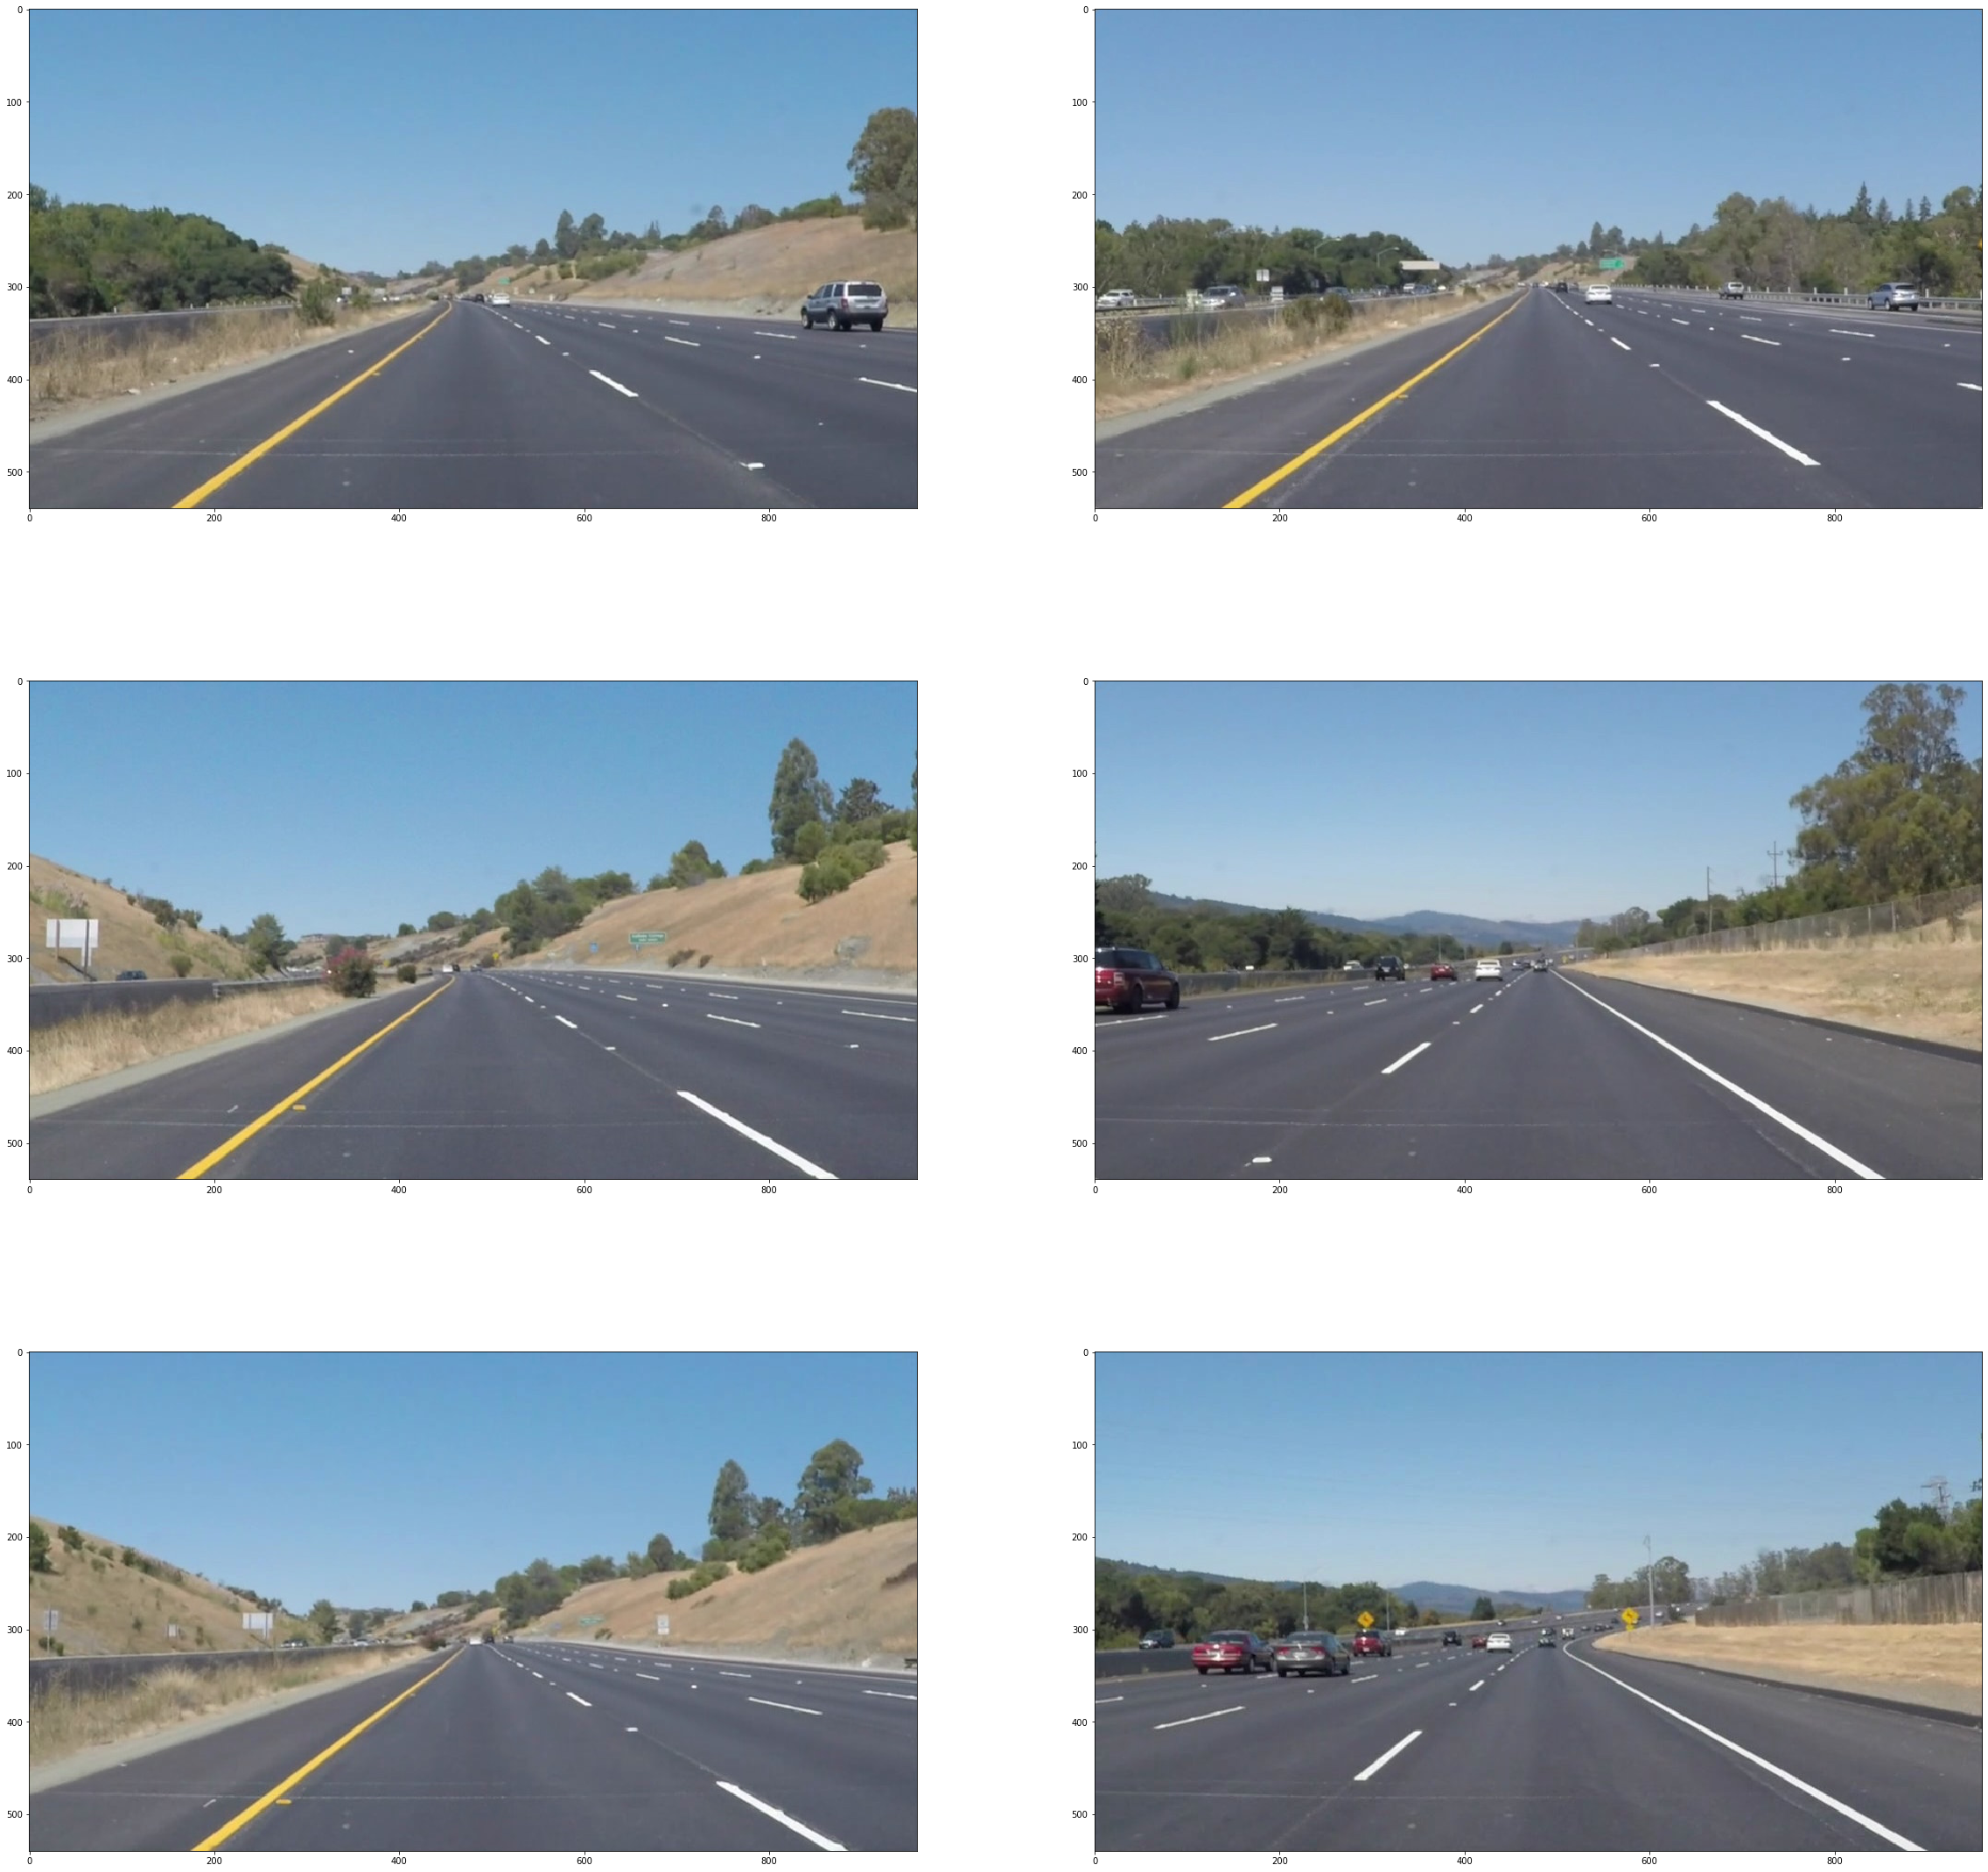

In [8]:
def display_images(images, cmap=None):
    plt.figure(figsize=(40,40))    
    for i, image in enumerate(images):
        plt.subplot(3,2,i+1)
        plt.imshow(image, cmap)
        plt.autoscale(tight=True)
    plt.show()
    
display_images(imageList)

In [15]:
def processImage(image):
    interest = roi(image)
    canny = cv2.Canny(grayscale(interest), 50, 120)
    myline = hough_lines(canny, 1, np.pi/180, 10, 20, 5)
    weighted_img = cv2.addWeighted(myline, 1, image, 0.8, 0)
    
    return weighted_img

## Step 1  (Focus on Region of Interest)

Removing the unwanted noise , we can narrow down where we're looking for lane lines by masking out a region of interest using the following function:

One of the pitfall about the approach is we are assuming that the vehicle is always going to be in this lane. Future consideration to make this more dynamic.

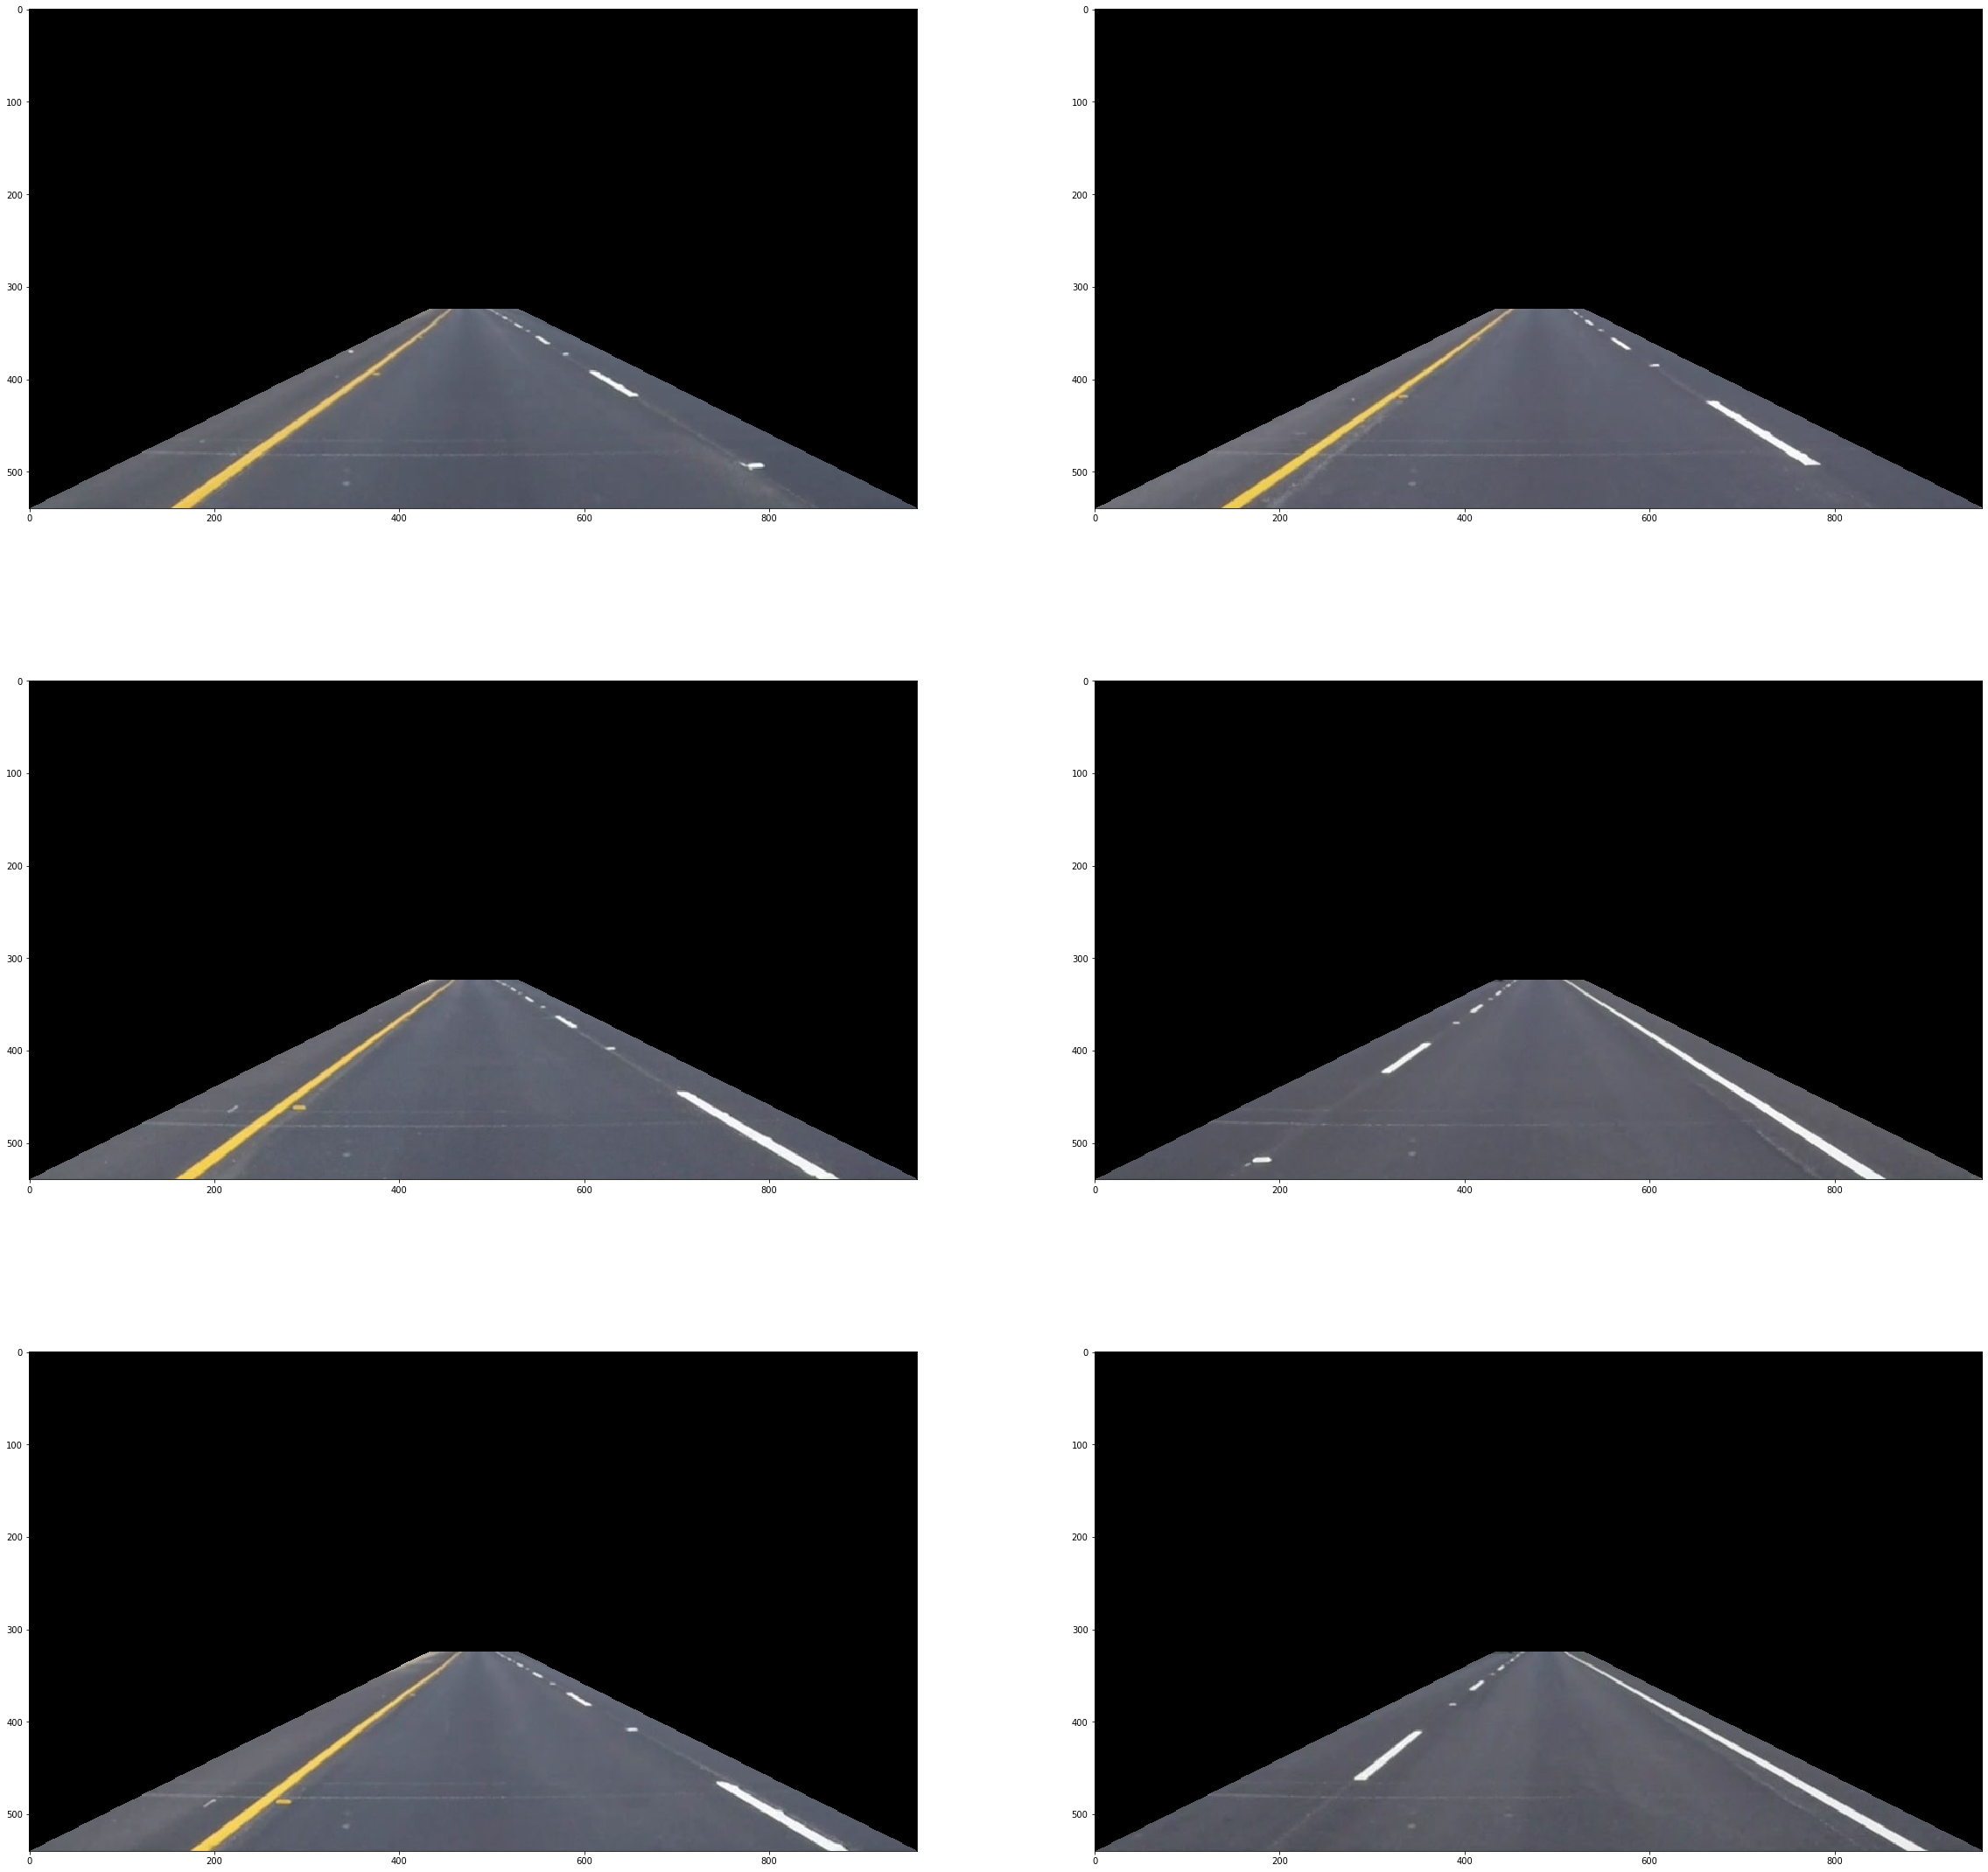

In [26]:
def roi(img):
    x = int(img.shape[1])
    y = int(img.shape[0])
    shape = np.array([[int(0), int(y)], [int(x), int(y)], [int(0.55*x), int(0.6*y)], [int(0.45*x), int(0.6*y)]])

    #define a numpy array with the dimensions of img, but comprised of zeros
    mask = np.zeros_like(img)

    # Mask the unwanted region
    
    ignore_mask_color = 255

    #creates a polygon with the mask color
    cv2.fillPoly(mask, np.int32([shape]), ignore_mask_color)

    #returns the image only where the mask pixels are not zero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

roi_img = list(map(roi, imageList))

display_images(roi_img)

## Step 2  (Edge Detection)

From the last step we isolated to lane of interest, we can compute the edges of the lane lines. This can easily be done using CannyEdgeDetection. 

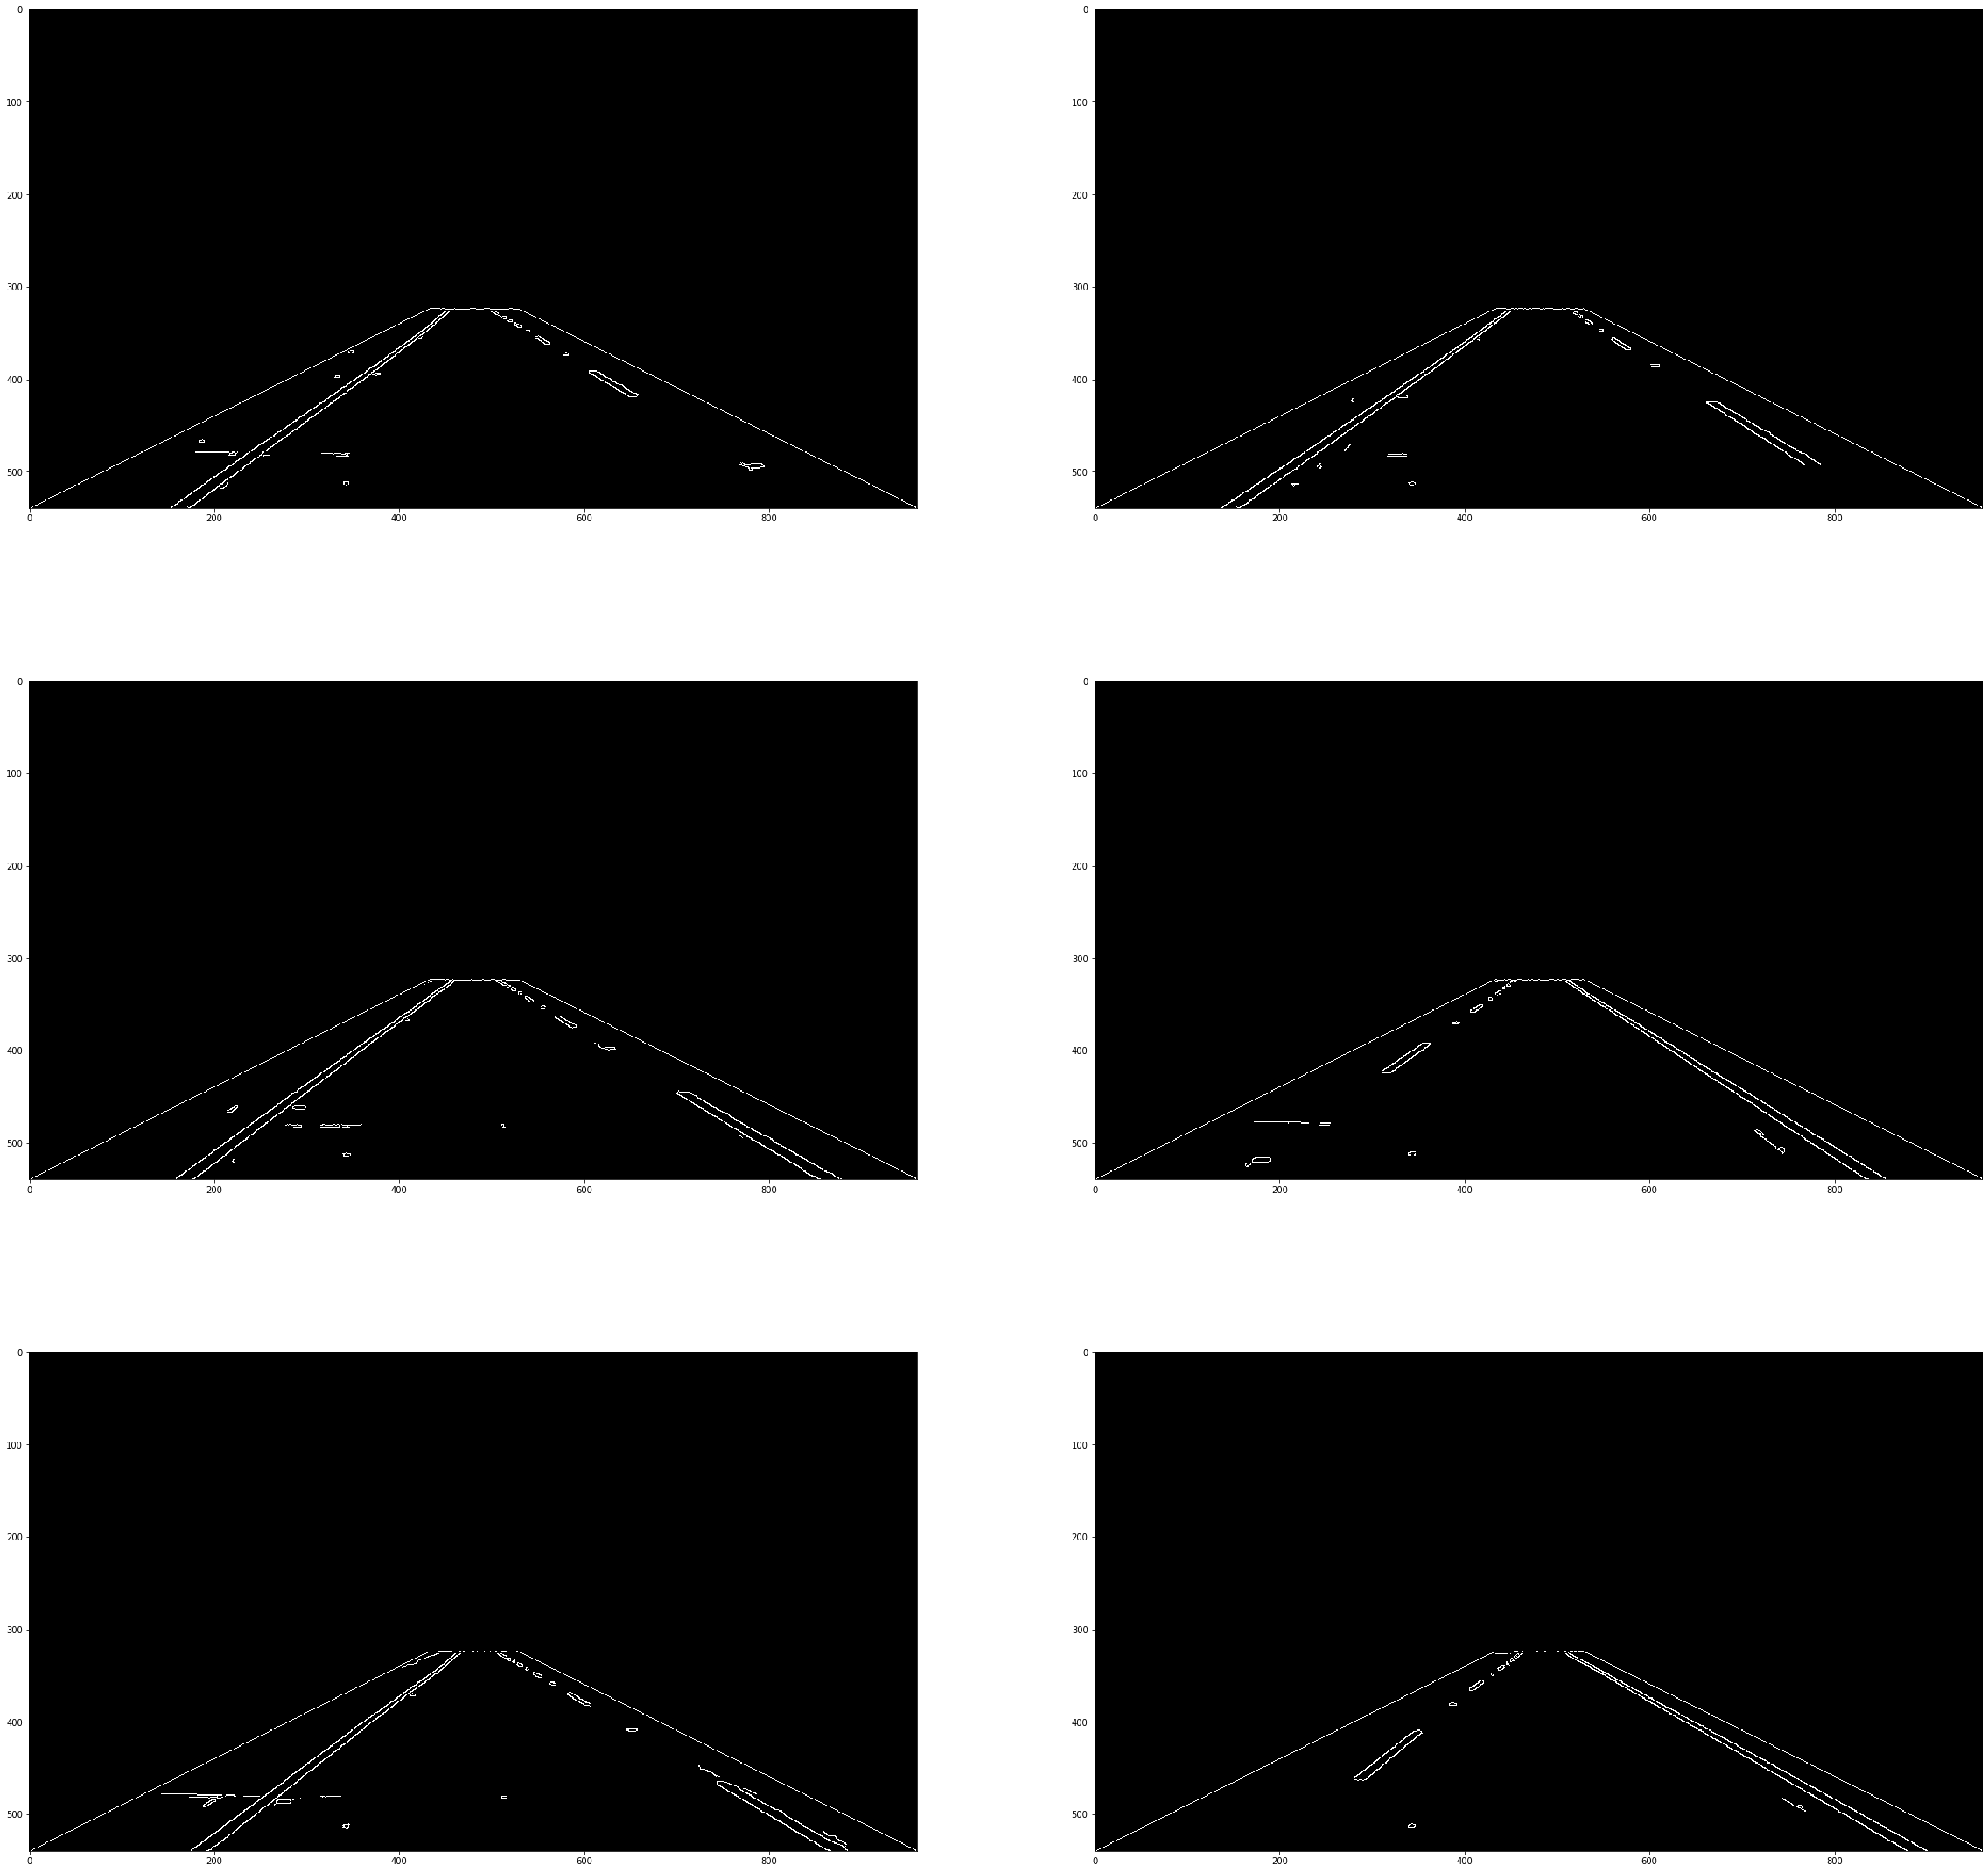

In [27]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img):
    return cv2.Canny(grayscale(img), 50, 120)

canny_img = list(map(canny, roi_img))
display_images(canny_img,cmap='gray')

## Step 3  (Line Detection With Hough Transform)

The main challenge is identifying right and left line from the lane from all other lines. Immediate challenge i experienced once i moved to Video frame to static images is the fit of the line to take into consideration of slight curve involved in the video. As instructed use the quadilateral line fitting to calculate the slope and intercept and average it over 30 frames to smooth out the curve handling. 

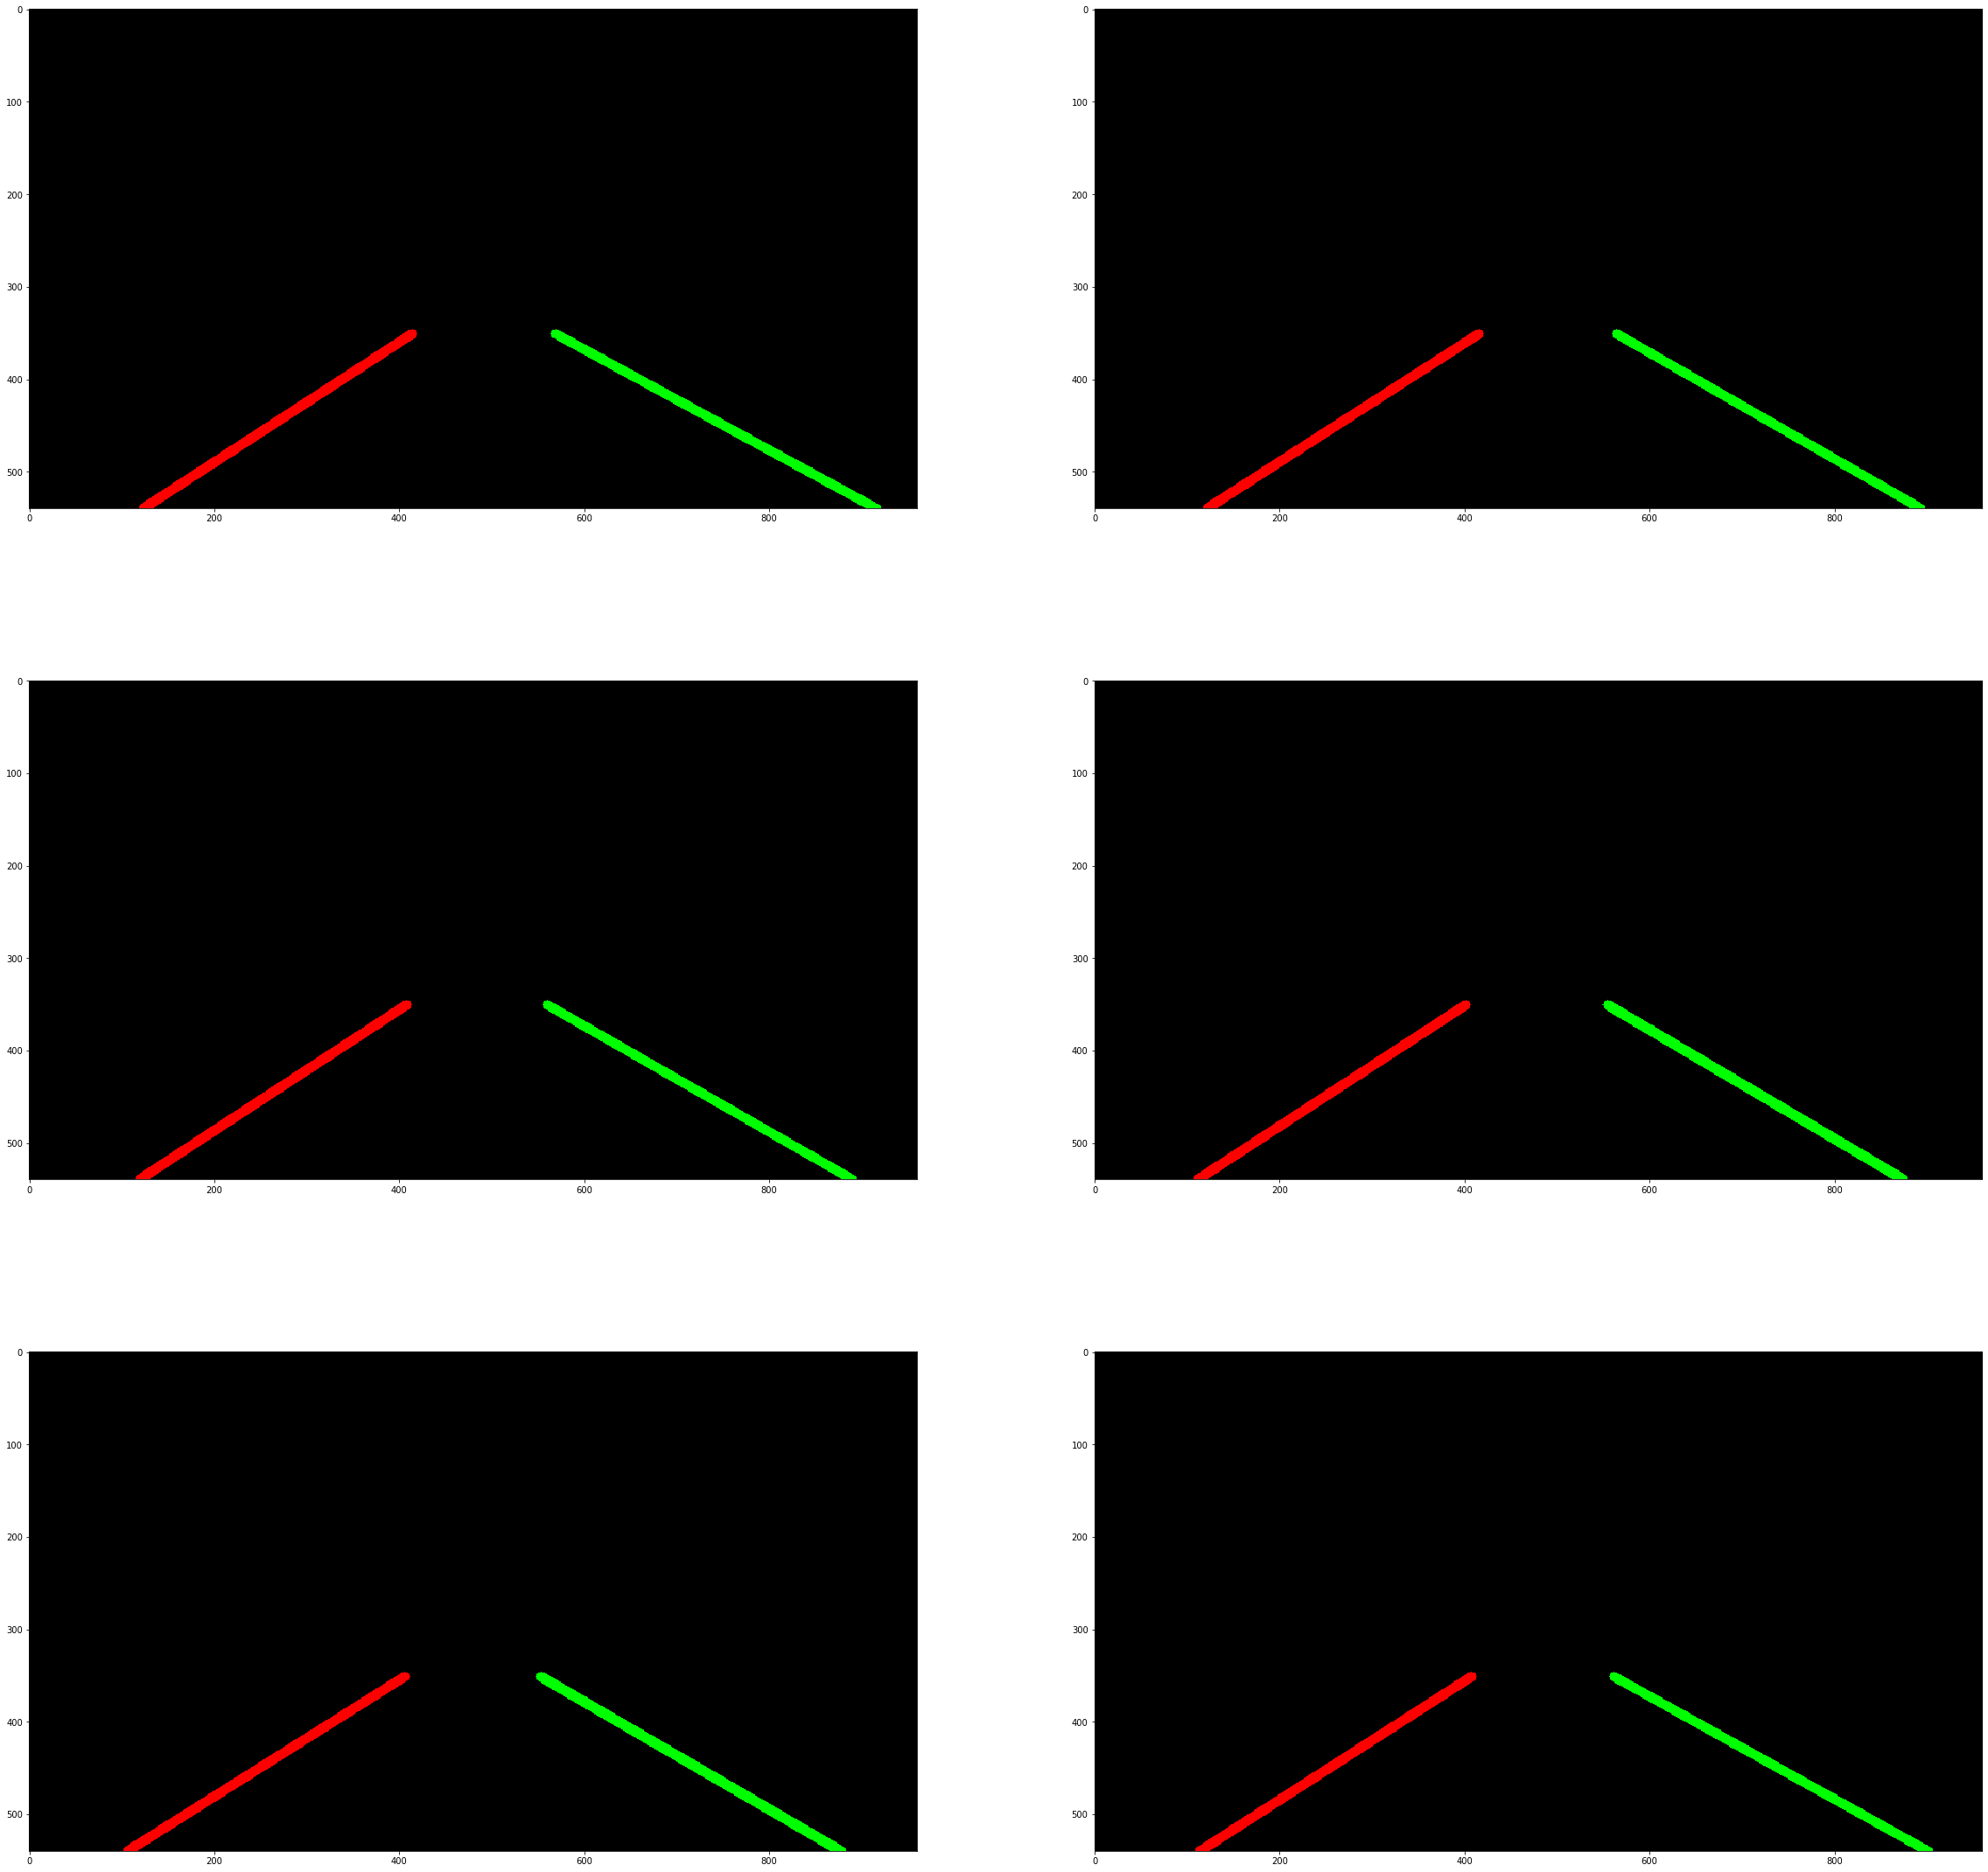

In [55]:

rightSlope, leftSlope, rightIntercept, leftIntercept = [],[],[],[]
def draw_lines(img, lines, thickness=5):
    global rightSlope, leftSlope, rightIntercept, leftIntercept
    rightColor=[0,255,0]
    leftColor=[255,0,0]
    
    #Just applying the polyfit technique introduced in the lecture , we can easily determine the slope and intercept.
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #slopeold = (y1-y2)/(x1-x2)
            parameters = np.polyfit((x1, x2), (y1, y2), 1)
            slope = parameters[0]
            #print (slopeold)
            #print (slope)
            yintercept = parameters[1]
            if slope > 0.3:
                if x1 > 500 :                
                    rightSlope.append(slope)
                    rightIntercept.append(yintercept)
                else: None                
            elif slope < -0.3:
                if x1 < 600:               
                    leftSlope.append(slope)
                    leftIntercept.append(yintercept)    
                    
                    
    # Averaging out the slope and intercept helps to handle various scenarious across the video frames 
    leftavgSlope = np.mean(leftSlope[-30:])
    leftavgIntercept = np.mean(leftIntercept[-30:])
    
    rightavgSlope = np.mean(rightSlope[-30:])
    rightavgIntercept = np.mean(rightIntercept[-30:])
    
    
    #Here we plot the lines and the shape of the lane using the average slope and intercepts
    try:
        left_line_x1 = int((0.65*img.shape[0] - leftavgIntercept)/leftavgSlope)
        left_line_x2 = int((img.shape[0] - leftavgIntercept)/leftavgSlope)
    
        right_line_x1 = int((0.65*img.shape[0] - rightavgIntercept)/rightavgSlope)
        right_line_x2 = int((img.shape[0] - rightavgIntercept)/rightavgSlope)

        pts = np.array([[left_line_x1, int(0.65*img.shape[0])],[left_line_x2, int(img.shape[0])],[right_line_x2, int(img.shape[0])],[right_line_x1, int(0.65*img.shape[0])]], np.int32)
        pts = pts.reshape((-1,1,2))
        #cv2.fillPoly(img,[pts],(0,0,255))      
        
        
        cv2.line(img, (left_line_x1, int(0.65*img.shape[0])), (left_line_x2, int(img.shape[0])), leftColor, 10)
        cv2.line(img, (right_line_x1, int(0.65*img.shape[0])), (right_line_x2, int(img.shape[0])), rightColor, 10)
    except ValueError:
            #Catch the errors which is outside of the approximation.
        pass
    
    
    
                
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines)
    return line_img

def linedetect(img):
    return hough_lines(img, 1, np.pi/180, 10, 10,60)

hough_img = list(map(linedetect, canny_img))
display_images(hough_img)


## Step 4  (Pipeline for SolidWhiteRight)

The following technique worked perfectly for this scenario as you can see from the output.


In [54]:
cap = cv2.VideoCapture("test_videos/solidWhiteRight.mp4")

if cap.isOpened():
            print("Device Opened\n")
            frame_width = int(cap.get(3))
            frame_height = int(cap.get(4))
            
else:
            print("Failed to open Device\n")



out = cv2.VideoWriter('test_videos_output/solidWhiteRight_Out.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(cap.isOpened()):
   
    
    ret, frame = cap.read()
    
    if ret == True:
        
        output = processImage(frame)
        #display_images(output)
        out.write(output)
        #plt.imshow(output,cmap='gray')
        #plt.show()
        
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    else:
        print( "Something Went Wrong \n")
        break

cap.release()
out.release()
print ('Done Lane Detection')
cv2.destroyAllWindows()

Device Opened

Something Went Wrong 

Done Lane Detection


## Step 5  (Pipeline for SolidYellowLeft)

The Yellow lane posed a different challenge without applying filters. After searching through the web i found the HLS on top of the existing pipeline allowed to detect the lines 



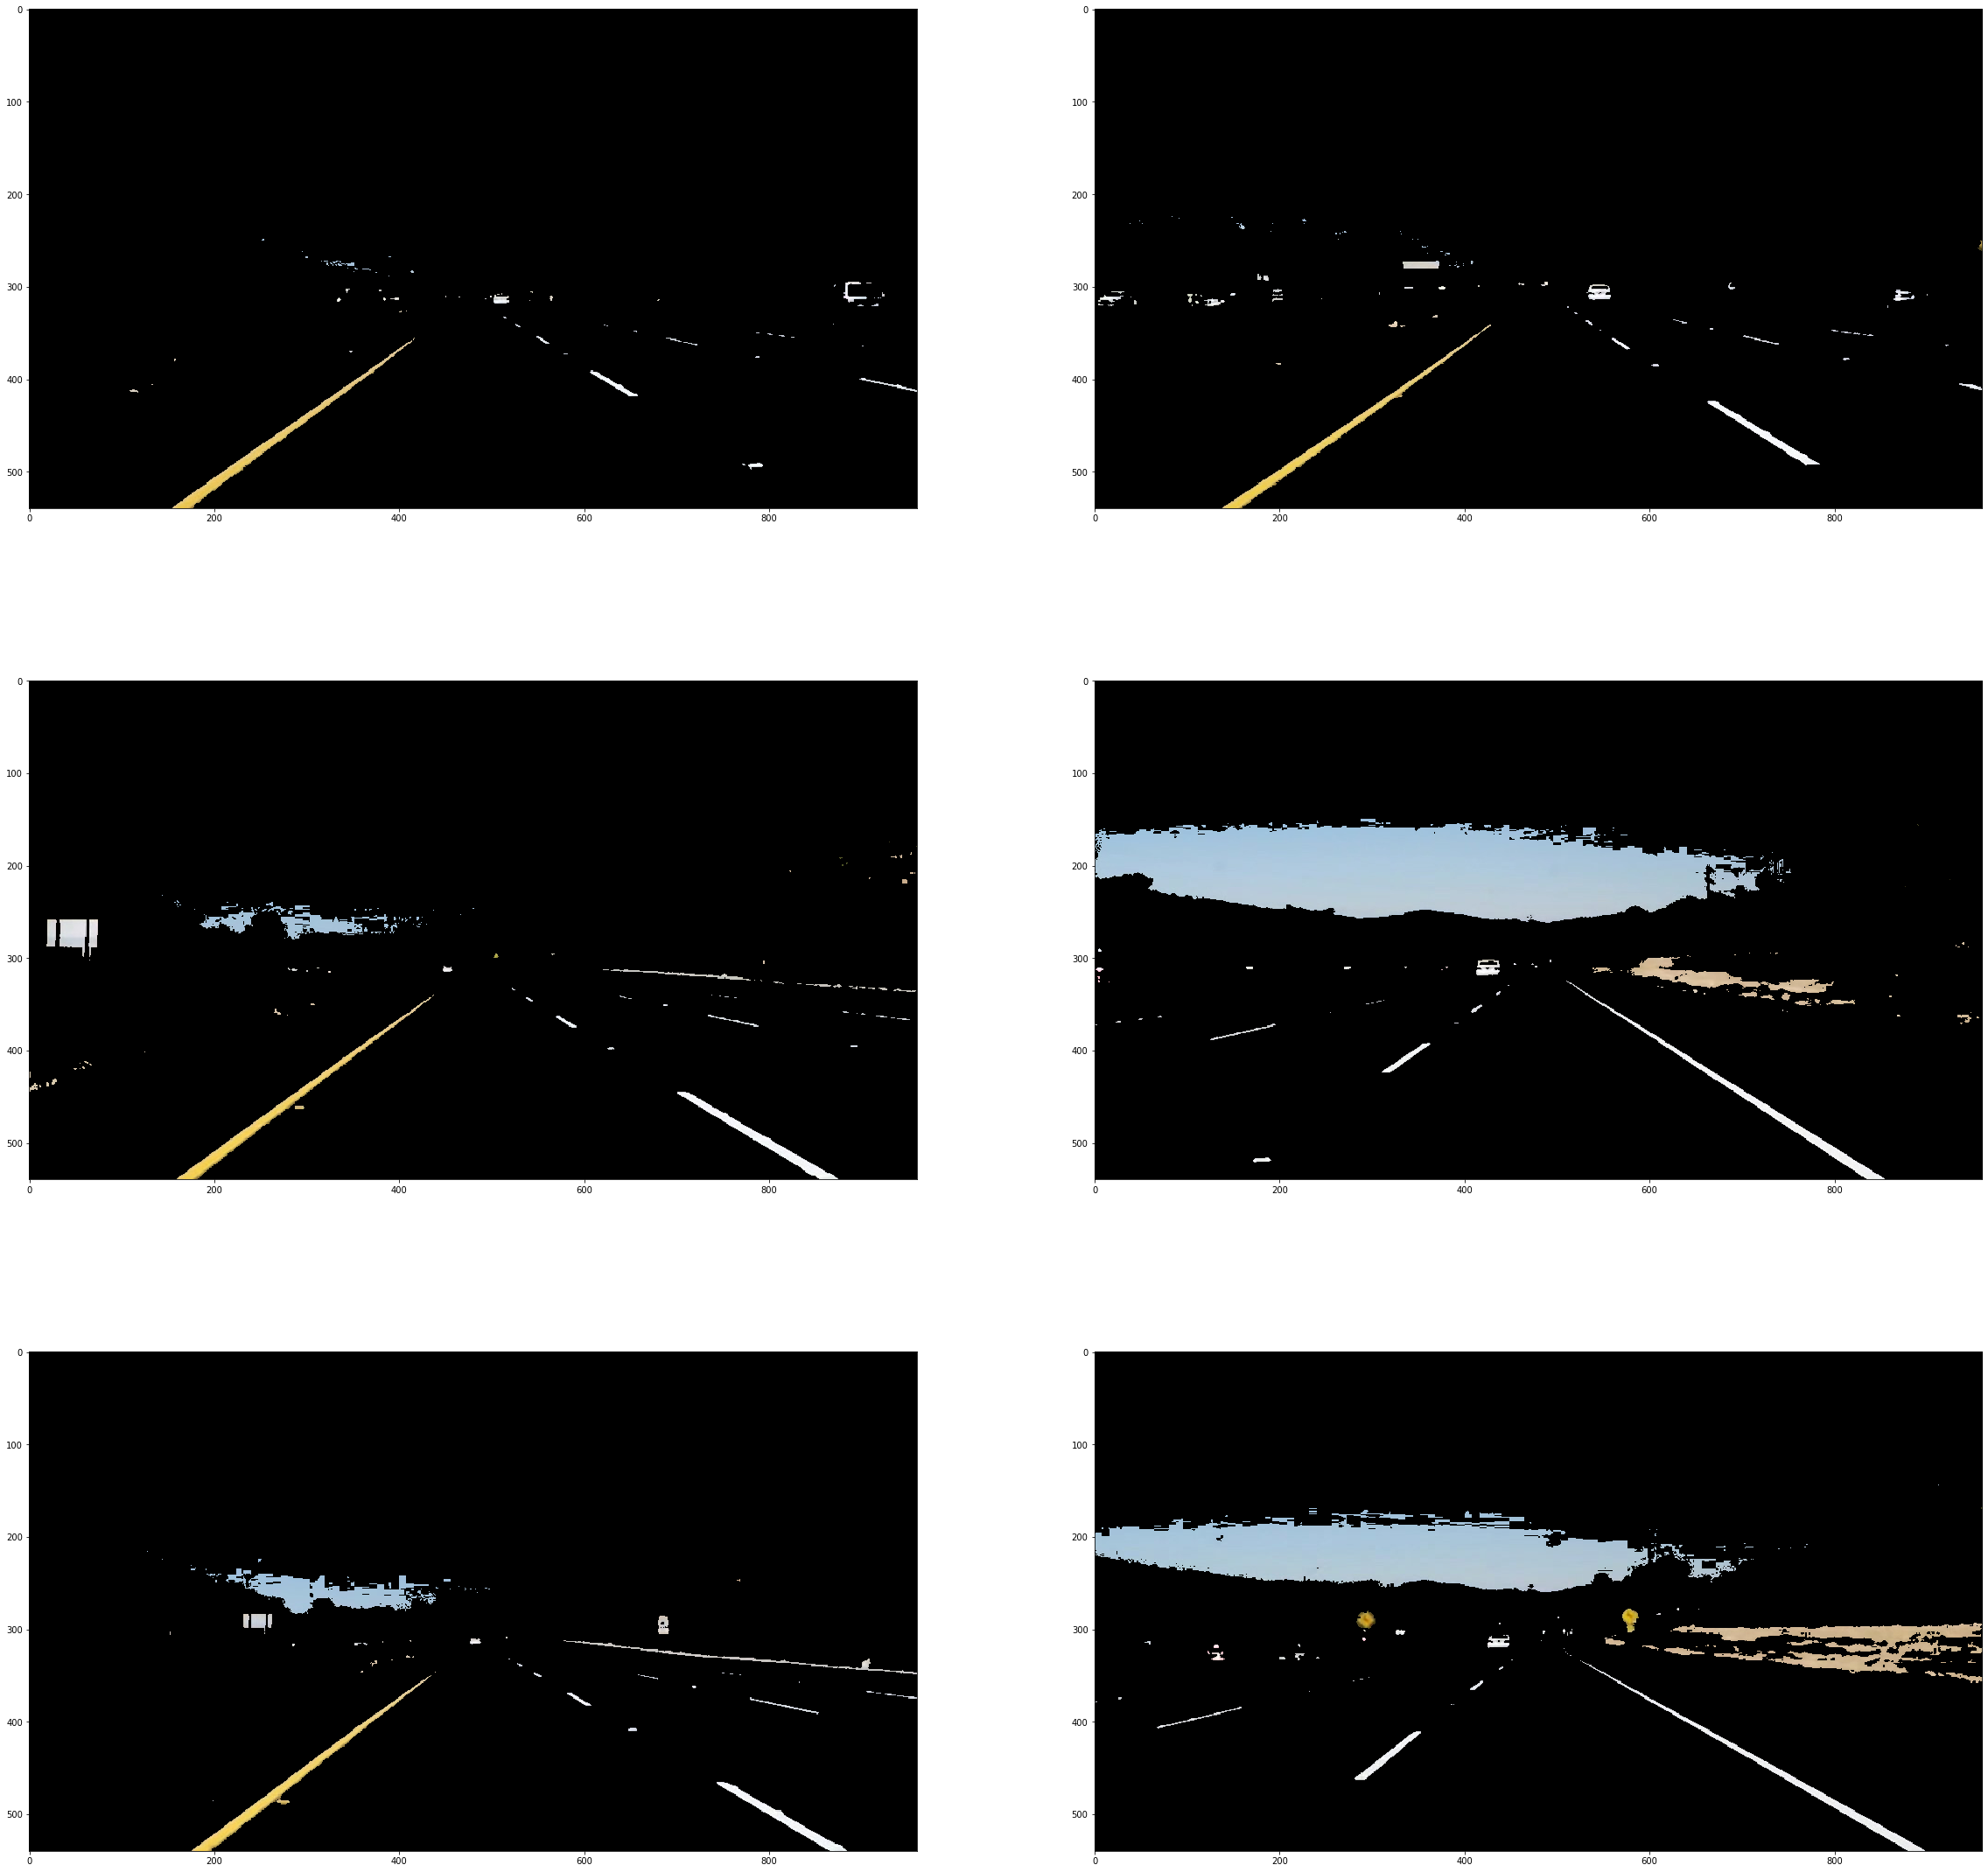

In [58]:
def color_filter(image):
    #convert to HLS to mask based on HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    lower = np.array([0,190,0])
    upper = np.array([255,255,255])
    
    yellower = np.array([10,0,90])
    yelupper = np.array([50,255,255])
    
    yellowmask = cv2.inRange(hls, yellower, yelupper)    
    whitemask = cv2.inRange(hls, lower, upper)
    
    mask = cv2.bitwise_or(yellowmask, whitemask)  
    masked = cv2.bitwise_and(image, image, mask = mask)    
    


    return masked

filtered_img = list(map(color_filter, imageList))

display_images(filtered_img)

In [60]:
def processImageV1(image):
    interest = roi(image)
    filterimg = color_filter(interest)
    canny = cv2.Canny(grayscale(filterimg), 50, 120)
    myline = hough_lines(canny, 1, np.pi/180, 10, 20, 5)
    weighted_img = cv2.addWeighted(myline, 1, image, 0.8, 0)
    
    return weighted_img

In [61]:
cap = cv2.VideoCapture("test_videos/solidYellowLeft.mp4")

if cap.isOpened():
            print("Device Opened\n")
            frame_width = int(cap.get(3))
            frame_height = int(cap.get(4))
            
else:
            print("Failed to open Device\n")



out = cv2.VideoWriter('test_videos_output/solidYellowLeft_Out.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(cap.isOpened()):
   
    
    ret, frame = cap.read()
    
    if ret == True:
        
        output = processImageV1(frame)
        #display_images(output)
        out.write(output)
        #plt.imshow(output,cmap='gray')
        #plt.show()
        
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    else:
        print( "Something Went Wrong \n")
        break

cap.release()
out.release()
print ('Done Lane Detection')
cv2.destroyAllWindows()

Device Opened

Something Went Wrong 

Done Lane Detection


## Optional Challenge


Current approach works well even for challenge video , but has several shortcomings

     * Handle more dynamic scenario as opposed to hard coding of region of interest  
     * Handling roads with more sharper curves.
 

In [56]:
cap = cv2.VideoCapture("test_videos/challenge.mp4")

if cap.isOpened():
            print("Device Opened\n")
            frame_width = int(cap.get(3))
            frame_height = int(cap.get(4))
            
else:
            print("Failed to open Device\n")



out = cv2.VideoWriter('test_videos_output/challenge_Out.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(cap.isOpened()):
   
    
    ret, frame = cap.read()
    
    if ret == True:
        
        output = processImageV1(frame)
        #display_images(output)
        out.write(output)
        #plt.imshow(output,cmap='gray')
        #plt.show()
        
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    else:
        print( "Something Went Wrong \n")
        break

cap.release()
out.release()
print ('Done Lane Detection')
cv2.destroyAllWindows()

Device Opened

Something Went Wrong 

Done Lane Detection
